## Clasificador plantas.
#### Hecho por: José Ignacio Salas Cáceres

En este programa se ha elaborado una red neuronal que pueda clasificar entre 10 plantas de la flora española.  
El dataset usado cuenta con 10 clases de 200 imágenes aprox. cada uno.  
Las imágenes de todo el grupo excepto el girasol proceden del Banco taxonómico Digital de la Flora Ibérica de la web Biodiversidadvirtual.org  (https://www.biodiversidadvirtual.org/herbarium/)    
Las imágenes del girasol proceden del dataset "Flower Recognition" de kaggle. (https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

El listado de plantas usado, con nombre científico y común, es el siguiente: 

 + n1 = Papaver rhoeas, Amapola
 + n2 = Aphyllanthes monspeliensis, chunqueta
 + n3 = Helianthus annuus, Girasol
 + n4 = Astragalus incanus, Piorno
 + n5 = Campanula rapunculus, Campanilla
 + n6 = Gynandriris sisyrinchium, lirio
 + n7 = Lonicera etrusca, madreselva
 + n8 = Oxalis pes crapae, Trebolina
 + n9 = Paronychia capitata, Hierba plateada
 + n10 = Vincetoxicum hirundinaria, Matatósico


En esta versión aplicamos Transfer Leaning con el modelo VGG16 y además Fine Tunning, entrenando las dos últimas capas de dicho modelo.

In [6]:
# Lo primero será acceder al drive donde tenemos las imagenes.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


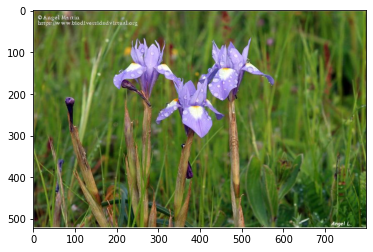

In [7]:
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf

path ='/content/drive/My Drive/Colab/Dataset_Plantas_Full/'
#Mostramos una imagen del conjunto como ejemplo

%matplotlib inline
pil_im = Image.open(path + '/n6/Gynandriris-sisyrinchium-(L.)-Parl.-498515.sm.jpg', 'r')
imshow(np.asarray(pil_im))


In [8]:
# DATA SOURCE --------------------------------------------------

image_size = (300,300)
batch_size = 64
_names = ['n1', 'n10', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
nombres = ['amapola','matatósico','chunqueta','girasol','Piorno','Campanula','lirio','MadreSelva','Trebolina','Hierba plateada']



# Ambos conjuntos estan en la misma carpeta, por lo que tendremos uqe crear una separacion entre train y test

# Defino el conjunto de entrenamiento con sus caracteristicas. Como son flores, necesitaremos las imagenes en rgb y como hay varias clases
# el label mode será categorical y no binary.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2, # La separación será del 80% train, 20% validation
    subset="training",
    seed=1337, #Le ponemos una seed para que la particion sea la misma en cada ejecución.
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 1960 files belonging to 10 classes.
Using 1568 files for training.
Found 1960 files belonging to 10 classes.
Using 392 files for validation.


In [9]:
# MODEL Transfer Learning y Fine Tunning  --------------------------------------------------

# Probar el anterior modelo cambiando el dropout y este haciendo variables los pesos solo de la ultima capa de convolutivas.

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from keras.callbacks import EarlyStopping

# Importamos el modelo base de la VGG16. Con los pesos del imagenet, sin la parte del final, que es la que cambiaremos
# y especificando el tamaño que va a tener la entrada. En nustro caso, 300x300x3.

base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(300, 300, 3),
    include_top=False) 

base_model.trainable = True

for capa in base_model.layers[:-2]:
  capa.trainable = False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

# Importado el VGG16, ahora vamos a crear nuestro modelo. Primero definimos la capa de entradas.

inputs = keras.Input(shape=(300, 300, 3))

# Destacar que de esta manera, el modelo se tiene que crear de forma funcional. añadiendo primero el modelo base y despues el resto.
# insertamos base_model
x = base_model(inputs)

# insertamos el globalpoolinh
x = keras.layers.GlobalAveragePooling2D()(x)

# Por ultimo al modelo añadimos una capa densa y la de salida con el sigmoide.
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

# Declaramos el modelo. 
modelT = keras.Model(inputs, outputs)


#Viendo el resumen del modelo podemos ver que las primeras capas, correspondientes a la VGG16 no son entrenables.
print(modelT.summary())



58889256/58889256 [==============================] - 4s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                       

In [ ]:
#modelT = keras.models.load_model("/content/drive/My Drive/Colab/pesosTunning.h5")

In [10]:
# TRAINING Entrenando ultimas 2 capas del VGG --------------------------------------------------

# Compilamos el modelo y especificamos la funcion de error (entropia cruzada) y el metodo de optimizacion, el adam.
modelT.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# Definimos elnumero de epocas
epochs = 50

# Definimos las condiciones para el early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

#entrenamos el modelo.

h = modelT.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/50
25/25 [==============================] - 877s 25s/step - loss: 5.9053 - accuracy: 0.4273 - val_loss: 1.1278 - val_accuracy: 0.6811
Epoch 2/50
25/25 [==============================] - 23s 833ms/step - loss: 0.6107 - accuracy: 0.8048 - val_loss: 0.6529 - val_accuracy: 0.7985
Epoch 3/50
25/25 [==============================] - 22s 803ms/step - loss: 0.2675 - accuracy: 0.9139 - val_loss: 0.4265 - val_accuracy: 0.8418
Epoch 4/50
25/25 [==============================] - 22s 797ms/step - loss: 0.1455 - accuracy: 0.9534 - val_loss: 0.4386 - val_accuracy: 0.8546
Epoch 5/50
25/25 [==============================] - 22s 807ms/step - loss: 0.0638 - accuracy: 0.9866 - val_loss: 0.3805 - val_accuracy: 0.8903
Epoch 6/50
25/25 [==============================] - 22s 808ms/step - loss: 0.0289 - accuracy: 0.9962 - val_loss: 0.3055 - val_accuracy: 0.8801
Epoch 7/50
25/25 [==============================] - 22s 803ms/step - loss: 0.0146 - accuracy: 0.9994 - val_loss: 0.3309 - val_accuracy: 0.8827


1/1 [==============================] - 0s 133ms/step
              precision    recall  f1-score   support

           0     0.9615    0.7353    0.8333        34
           1     0.8250    0.7500    0.7857        44
           2     0.8864    0.9070    0.8966        43
           3     0.9184    1.0000    0.9574        45
           4     0.9630    0.8966    0.9286        29
           5     0.8947    0.8500    0.8718        40
           6     0.9545    0.9545    0.9545        44
           7     0.8511    0.9524    0.8989        42
           8     0.8438    0.8710    0.8571        31
           9     0.8444    0.9500    0.8941        40

    accuracy                         0.8903       392
   macro avg     0.8943    0.8867    0.8878       392
weighted avg     0.8924    0.8903    0.8889       392



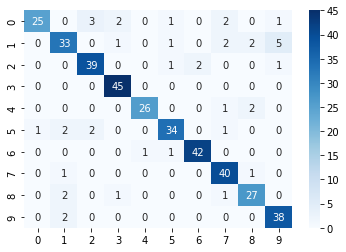

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#Realizado el entrenamiento, vamos a crear la matriz de confusion para entender mejor los resultados.

results = np.concatenate([(y, modelT.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[1], axis=1)
labels = np.argmax(results[0], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

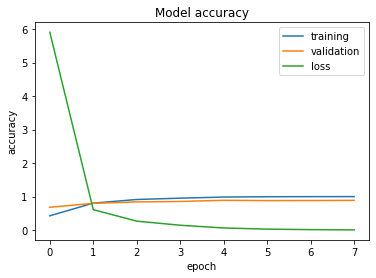

In [12]:
import matplotlib.pyplot as plt

# Vamos a graficar tambien la variacion de las precisiones y del loss con las epochs.

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

In [15]:
#modelT.save("/content/drive/My Drive/Colab/pesosTunning.h5")